#### Constant Velocity Model in 3D space

\begin{align*}
x(k+1)=Fx(k)+u(k)\\
x=[x,\dot{x},y,\dot{y},z,\dot{z}]'
\end{align*}
where the transition matrix $F$ is 
\begin{align*}
F=\left[\begin{matrix}
F_1 & 0 & 0 \\
0 & F_1 & 0 \\
0 & 0 & F_1
\end{matrix}\right],\quad 
F_1=\left[
\begin{matrix}
1 & T\\
0 & 1
\end{matrix}\right]
\end{align*}

The noise process $u(k)$ is assumed zero-mean white with covariance
\begin{align*}
Q=\left[
\begin{matrix} 
u_1 & 0 & 0 \\
0 & u_1 & 0\\
0 & 0 & u_1
\end{matrix}\right],\quad 
u_1=\left[\begin{matrix}
T^4/4 & T^3/2\\
T^3/2 & T^2
\end{matrix}
\right]q1
\end{align*}

The general measurement update is 
\begin{align*}
z_k=h(x_k)+v_k
\end{align*}

\begin{align*}
h=\left[
\begin{matrix}
r_1 \\
\theta_1 \\
\varphi_1\\
r_2\\
\theta_2\\
\varphi_2
\end{matrix}
\right] =\left[\begin{matrix}
\sqrt{x^2+y^2+z^2} \\
arctan(y/x)\\
arctan(z/\sqrt{x^2+y^2}) \\
\sqrt{x^2+y^2+z^2} \\
arctan(y/x)\\
arctan(z/\sqrt{x^2+y^2})
\end{matrix}\right],\quad
cov(v_k)=diag(\sigma_{r_1}^2,\sigma_{\theta_1}^2,\sigma_{\varphi}^2,\sigma_{r_2}^2,\sigma_{\theta_2}^2,\sigma_{\varphi_2}^2)
\end{align*}

#### Parameters Setting

$x_0=[900,50,950,40,850,60]'$


In [1]:
#--------------------------------------
# library loading
#--------------------------------------
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#set suppress to not use scientific counting
np.set_printoptions(suppress=True) 

#----------------------------------------
# Initialization Math Model
#----------------------------------------
cpu_start=time.perf_counter()

# q1: variance of the process noise modeling the acceleration
T=1; q1=1
# qa1, qa2: variance for azimuth from sensor 1,2 resp.
# qr, qe: variance for range and elevation resp.
qr1=20; qtheta1=7; qphi1=1;
qr2=10; qtheta2=2; qphi2=2;

dimX=6; dimY=6
N=1000; n0=50; N_sample= 1000

#Deterministic Matrix
F0=np.array([[1,T,0,0,0,0],
            [0,1,0,0,0,0],
            [0,0,1,T,0,0],
            [0,0,0,1,0,0],
            [0,0,0,0,1,T],
            [0,0,0,0,0,1]])

x0=np.array([[900],
             [50],
             [950],
             [40],
             [850],
             [60]])

#Covariance Matrix for random variable
#random variable u_n
Q0=np.array([[np.power(T,4)*q1/4,np.power(T,3)*q1/2,0,0,0,0],
             [np.power(T,3)*q1/2,np.power(T,2)*q1,0,0,0,0],
             [0,0,np.power(T,4)*q1/4,np.power(T,3)*q1/2,0,0],
             [0,0,np.power(T,3)*q1/2,np.power(T,2)*q1,0,0],
             [0,0,0,0,np.power(T,4)*q1/4,np.power(T,3)*q1/2],
             [0,0,0,0,np.power(T,3)*q1/2,np.power(T,2)*q1]])

#random variable v_n/w_n
#R0=np.diag((qa1,qr,qa2,qe))
R0=np.diag([np.square(qr1),np.square(qtheta1),np.square(qphi1),np.square(qr2),np.square(qtheta2),np.square(qphi2)])

# generate u_n, v_n
# 1-d Gaussian: np.random.default_rng().normal(mean, std, size)
# n-d Gaussian: np.random.default_rng().multivariate_normal(mean,cov,size)
# note to reshape multivariate normal random variable to column vector.
rng=np.random.default_rng()
u=[rng.multivariate_normal(np.zeros(dimX),Q0,1).reshape(dimX,1) for i in range(N)] #!!!
v=[rng.multivariate_normal(np.zeros(dimY),R0,1).reshape(dimY,1) for i in range(N+1)] #!!!
u=np.array(u)
v=np.array(v)

#-----------------------------
# Function Definition
#-----------------------------
def f(x):
    return F0@x
def g(x):
    return np.eye(len(x))
def h(x):
    """
    input x is a 6-dim col vector, 
    return a 4-dim col vector."""
    res=np.zeros((dimY,1))
    res[0]=np.sqrt(np.square(x[0])+np.square(x[2])+np.square(x[4]))
    res[1]=np.arctan(x[2]/x[0])
    res[2]=np.arctan(x[4]/np.sqrt(np.square(x[0])+np.square(x[2])))
    res[3]=np.sqrt(np.square(x[0])+np.square(x[2])+np.square(x[4]))
    res[4]=np.arctan(x[2]/x[0])
    res[5]=np.arctan(x[4]/np.sqrt(np.square(x[0])+np.square(x[2])))
    return res
def F(x):
    """Derivative of f """
    return F0
def G(x):
    """Derivative of g """
    return np.eye(dimX)
def H(x):
    """
    Derivative of h
    input a 6-dim col vector, return dimYx6 matrix."""
    res=np.zeros((dimY,dimX))
    res[0][0]=x[0]/np.sqrt(np.square(x[0])+np.square(x[2])+np.square(x[4]))
    res[0][2]=x[2]/np.sqrt(np.square(x[0])+np.square(x[2])+np.square(x[4]))
    res[0][4]=x[4]/np.sqrt(np.square(x[0])+np.square(x[2])+np.square(x[4]))
    
    res[1][0]=-x[2]/(np.square(x[0])+np.square(x[2]))
    res[1][2]=x[0]/(np.square(x[0])+np.square(x[2]))
    
    res[2][0]=-(x[0]*x[4])/(np.sqrt(np.square(x[0])+np.square(x[2]))*(np.square(x[0])+np.square(x[2])+np.square(x[4])))
    res[2][2]=-(x[2]*x[4])/(np.sqrt(np.square(x[0])+np.square(x[2]))*(np.square(x[0])+np.square(x[2])+np.square(x[4])))
    res[2][4]=np.sqrt(np.square(x[0])+np.square(x[2]))/(np.square(x[0])+np.square(x[2])+np.square(x[4]))
    
    res[3][0]=x[0]/np.sqrt(np.square(x[0])+np.square(x[2])+np.square(x[4]))
    res[3][2]=x[2]/np.sqrt(np.square(x[0])+np.square(x[2])+np.square(x[4]))
    res[3][4]=x[4]/np.sqrt(np.square(x[0])+np.square(x[2])+np.square(x[4]))
    
    res[4][0]=-x[2]/(np.square(x[0])+np.square(x[2]))
    res[4][2]=x[0]/(np.square(x[0])+np.square(x[2]))
    
    res[5][0]=-(x[0]*x[4])/(np.sqrt(np.square(x[0])+np.square(x[2]))*(np.square(x[0])+np.square(x[2])+np.square(x[4])))
    res[5][2]=-(x[2]*x[4])/(np.sqrt(np.square(x[0])+np.square(x[2]))*(np.square(x[0])+np.square(x[2])+np.square(x[4])))
    res[5][4]=np.sqrt(np.square(x[0])+np.square(x[2]))/(np.square(x[0])+np.square(x[2])+np.square(x[4]))
    
    return res

#-------------------------------------
# Extended KF Monte Carlo
#-------------------------------------
def ekf_mc():
    x_raw=np.zeros((N+1,dimX,1)); x_raw[0]=x0
    y_raw=np.zeros((N+1,dimY,1))
    y_raw[0]=h(x_raw[0])+v[0]

    for k in range(N):
        x_raw[k+1]=F0@x_raw[k]+u[k]  #!!! here is u[k]
        y_raw[k+1]=h(x_raw[k+1])+v[k+1]
        
    return x_raw,y_raw

#-------------------------------------
# Extended Kalman Filter Algorithm
#-------------------------------------

def extended_kf(f,g,h,F,G,H,Q0,R0,x0,y_raw):
    """
    f,g,h,F,G,H are all functions.
    Q0: covariance matrix of u_n
    R0: covariance matrix of v_n """
    x_hat=np.zeros((N+1,dimX,1)); x_hat[0]=x0
    R=np.zeros((N+1,dimX,dimX)); R[0]=np.eye(dimX) #!!!!!!
    x_bar=np.zeros((N+1,dimX,1)) 
    x_bar[0]=x_hat[0]+R[0]@H(x_hat[0]).T@np.linalg.inv(H(x_hat[0])@R[0]@H(x_hat[0]).T+R0)@(y_raw[0]-h(x_hat[0]))
    
    for k in range(N):   
        x_hat[k+1]=f(x_bar[k])
        inv_pre=np.linalg.inv(H(x_hat[k])@R[k]@H(x_hat[k]).T+R0)
        R[k+1]=F(x_bar[k])@(R[k]-R[k]@H(x_hat[k]).T@inv_pre@H(x_hat[k])@R[k])@F(x_bar[k]).T+G(x_bar[k])@Q0@G(x_bar[k]).T
        inv_pos=np.linalg.inv(H(x_hat[k+1])@R[k+1]@H(x_hat[k+1]).T+R0)
        x_bar[k+1]=x_hat[k+1]+R[k+1]@H(x_hat[k+1]).T@inv_pos@(y_raw[k+1]-h(x_hat[k+1]))
        
    return x_hat,x_bar


#-----------------------------------------------------------------------------------------
# Generating tons of samples
#-----------------------------------------------------------------------------------------

def sample_generator():
    
    datas=np.zeros(((N-n0+2)*N_sample,n0,dimY)) #for each sample path, we have N-n0+2 data
    labels=np.zeros(((N-n0+2)*N_sample,dimX))
    
    x_bars=np.zeros(((N-n0+2)*N_sample,dimX)) #store Kalman filtering estimation value.
    x_hats=np.zeros(((N-n0+2)*N_sample,dimX))
    
    x_raws=np.zeros((N_sample, N+1, dimX, 1))
    y_raws=np.zeros((N_sample, N+1, dimY, 1))
    
    for i in range(N_sample):
        data=np.zeros((N-n0+2,n0,dimY)) #store data for each sample
        label=np.zeros((N-n0+2,dimX))
        # call ekf_mc function to generate sample
        x_raw,y_raw=ekf_mc()
        x_raws[i]=x_raw; y_raws[i]=y_raw
        
        # call extended_kf function to compute estimation
        # make sure here y_raw to be column vector
        x_hat, x_bar=extended_kf(f,g,h,F,G,H,Q0,R0,x0,y_raw)
        
        #---- convert x_raw, y_raw, x_hat, x_bar into row vector for each element---------
        #---------------------------------------------------------------------------------
        x_raw=x_raw.reshape(N+1,dimX) 
        y_raw=y_raw.reshape(N+1,dimY)
        x_hat=x_hat.reshape(N+1,dimX)
        x_bar=x_bar.reshape(N+1,dimX)
        # make data and label for each sample
        for k in range(N-n0+2):
            data[k]=y_raw[k:k+n0]
            label[k]=x_raw[k+n0-1]
            
        # put data and label into datas and labels with i representing sample number
        datas[i*(N-n0+2):(i+1)*(N-n0+2)]=data
        labels[i*(N-n0+2):(i+1)*(N-n0+2)]=label
        x_hats[i*(N-n0+2):(i+1)*(N-n0+2)]=x_hat[n0-1:]
        x_bars[i*(N-n0+2):(i+1)*(N-n0+2)]=x_bar[n0-1:]
    
    return datas,labels,x_hats,x_bars,x_raws,y_raws

#-----------------------------
# Data Preparation
#-----------------------------
# call sample_generator function to generate sample
datas, labels, x_hats,x_bars,x_raws, y_raws=sample_generator()
datas=datas.reshape(((N-n0+2)*N_sample,dimY*n0))
# convert numpy array into pandas dataframe
datas=pd.DataFrame(datas)
labels=pd.DataFrame(labels)
x_hats=pd.DataFrame(x_hats)
x_bars=pd.DataFrame(x_bars)

Epoch 1/10
47600/47600 [==============================] - 21s 437us/step - loss: 0.4380 - mean_squared_error: 0.4380
Epoch 2/10
47600/47600 [==============================] - 21s 436us/step - loss: 0.1453 - mean_squared_error: 0.1453
Epoch 3/10
47600/47600 [==============================] - 21s 435us/step - loss: 0.1330 - mean_squared_error: 0.1330
Epoch 4/10
47600/47600 [==============================] - 21s 434us/step - loss: 0.1207 - mean_squared_error: 0.1207
Epoch 5/10
47600/47600 [==============================] - 21s 435us/step - loss: 0.1151 - mean_squared_error: 0.1151
Epoch 6/10
47600/47600 [==============================] - 21s 435us/step - loss: 0.1132 - mean_squared_error: 0.1132
Epoch 7/10
47600/47600 [==============================] - 21s 433us/step - loss: 0.1125 - mean_squared_error: 0.1125
Epoch 8/10
47600/47600 [==============================] - 21s 433us/step - loss: 0.1120 - mean_squared_error: 0.1120
Epoch 9/10
47600/47600 [==============================] - 21s 43

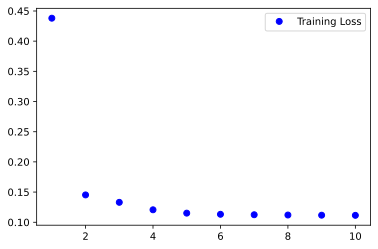

In [2]:
#### Data Normalization/Scaling

#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
seed=3
np.random.seed(seed)
training_data, test_data, training_label, test_label=train_test_split(datas,labels, test_size=0.2, random_state=seed)

#scaler_data=StandardScaler()
#scaler_label=StandardScaler()
# Always remember only use training data to do normalization and then apply it to test!
#training_data=scaler_data.fit_transform(training_data)
#training_label=scaler_label.fit_transform(training_label)
#test_data=scaler_data.transform(test_data)
#test_label=scaler_label.transform(test_label)

# Input normalization
data_mean=training_data.mean(axis=0)
data_std=training_data.std(axis=0)
training_data=(training_data-data_mean)/data_std
test_data=(test_data-data_mean)/data_std

# Output normalization
label_mean=training_label.mean(axis=0)
label_std=training_label.std(axis=0)
training_label=(training_label-label_mean)/label_std
test_label=(test_label-label_mean)/label_std

#-------------------------------
# Model building
#-------------------------------

from keras import models
from keras import layers
from keras import optimizers

def build_model():
    model=models.Sequential()
    model.add(layers.Dense(5,activation='relu',input_shape=(dimY*n0,)))
    model.add(layers.Dense(5,activation='relu'))
    model.add(layers.Dense(5,activation='relu'))
    model.add(layers.Dense(5,activation='relu'))
    model.add(layers.Dense(5,activation='relu'))
    model.add(layers.Dense(dimX))
              
    model.compile(optimizer=optimizers.SGD(lr=0.001), 
                  loss='mean_squared_error', 
                  metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

model=build_model()
mymodel=model.fit(training_data,training_label, epochs=10, batch_size=16)

#-------------------------------
# Evaluation Performance
#-------------------------------

from sklearn.metrics import mean_squared_error

test_mse_score, test_mae_score=model.evaluate(test_data,test_label)

index=test_label.index.tolist()
# Need to do same normalization with deep filtering to compare.
x_bars=(x_bars-label_mean)/label_std
kf_mse_err=mean_squared_error(x_bars.iloc[index],test_label) #labels.iloc[index]

cpu_end=time.perf_counter()

print("The mse of deep filtering is {:.3%}".format(test_mse_score))
print("The mse of Kalman Filtering is {:.3%}".format(kf_mse_err))
print("The CPU consuming time is {:.5}".format(cpu_end-cpu_start))

history_dict=mymodel.history
loss_value=history_dict['loss']
#val_loss_value=history_dict['val_loss']
epochs=range(1,10+1)
import matplotlib.pyplot as plt
plt.plot(epochs, loss_value, 'bo',label='Training Loss')
#plt.plot(epochs, val_loss_value,'b',label='Validation Loss')
plt.legend()
plt.show()

In [3]:
#-------------------------------------------------------------
# plot on new data
#-------------------------------------------------------------
x_new, y_new=ekf_mc()
x_hat_new, x_bar_new=extended_kf(f,g,h,F,G,H,Q0,R0,x0,y_new)
y_new=y_new.reshape(N+1,dimY)
data_new=np.zeros((N-n0+2,n0,dimY))
for k in range(N-n0+2):
    data_new[k]=y_new[k:k+n0]
# convert data to be consistent with deep learning.
data_new=data_new.reshape(N-n0+2,n0*dimY)
data_new=pd.DataFrame(data_new)

In [4]:
# Before predict, normalize data with training information.
data_new=(data_new-data_mean)/data_std
df_pred=model.predict(data_new)
for i in range(N-n0+2):
    # convect df results back to original scale.
    df_pred[i,:]=df_pred[i,:]*label_std+label_mean

In [5]:
df_new=[x0 for k in range(n0-1)]
df_new=np.array(df_new)
df_new=df_new.reshape(n0-1,dimX)
df_new=np.vstack((df_new,df_pred))

<Figure size 24000x18000 with 0 Axes>

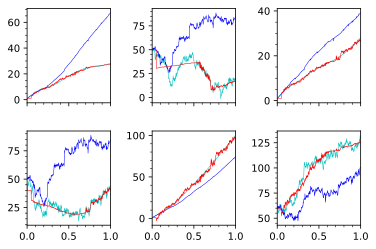

In [6]:
# import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(dpi = 600,figsize=[40,30])
axis=np.linspace(0,1,N+1)
fig,ax=plt.subplots(2,3,sharex=True)
plt.xlim((0,1))
ax[0][0].plot(axis, x_new[:,0]/1000,'c',axis,x_bar_new[:,0]/1000,'b',axis,df_new[:,0]/1000,'r',linewidth=0.5)
ax[0][0].set_xlim((0,1))
ax[0][0].minorticks_on()
ax[0][1].plot(axis, x_new[:,1],'c',axis,x_bar_new[:,1],'b',axis,df_new[:,1],'r',linewidth=0.5)
ax[0][1].minorticks_on()
ax[0][2].plot(axis, x_new[:,2]/1000,'c',axis,x_bar_new[:,2]/1000,'b',axis,df_new[:,2]/1000,'r',linewidth=0.5)
ax[0][2].minorticks_on()
ax[1][0].plot(axis, x_new[:,3],'c',axis,x_bar_new[:,1],'b',axis,df_new[:,3],'r',linewidth=0.5)
ax[1][0].minorticks_on()
ax[1][1].plot(axis, x_new[:,4]/1000,'c',axis,x_bar_new[:,4]/1000,'b',axis,df_new[:,4]/1000,'r',linewidth=0.5)
ax[1][1].minorticks_on()
ax[1][2].plot(axis, x_new[:,5],'c',axis,x_bar_new[:,5],'b',axis,df_new[:,5],'r',linewidth=0.5)
ax[1][2].minorticks_on()
fig.subplots_adjust(wspace=0.5, hspace=0.3)
plt.savefig('6dim-plot.pdf')
plt.show()

In [ ]:
#-------------------------------
# Data backup or Store
#--------------------------------
# store Monte Carlo sample data
np.save(file='datas/df-CV3D-m6-x_raws.npy',arr=x_raws)
np.save(file='datas/df-CV3D-m6-y_raws.npy',arr=y_raws)
# Store training and test data
store=pd.HDFStore('datas/df-CV3D-m6_datas.h5')
store['datas']=datas
store['labels']=labels
store['x_hats']=x_hats
store['x_bars']=x_bars
store['training_data']=training_data
store['training_label']=training_label
store['data_mean']=data_mean
store['data_std']=data_std
store['test_data']=test_data
store['test_label']=test_label
store['label_mean']=label_mean
store['label_std']=label_std
# store DNN model
model.save('datas/df-CV3D-m6-model.h5',overwrite=True)
# store path data
np.save(file='datas/df-CV3D-m6-x_new',arr=x_new)
np.save(file='datas/df-CV3D-m6-y_new',arr=y_new)
np.save(file='datas/df-CV3D-m6-x_bar_new',arr=x_bar_new)
np.save(file='datas/df-CV3D-m6-df_new',arr=df_new)